In [48]:
import numpy as np
from sklearn import preprocessing, cross_validation, neighbors
import pandas as pd

df = pd.read_csv('breast-cancer-wisconsin.data.txt')
df.replace('?',-99999, inplace=True)
df.drop(['id'], 1, inplace=True)
df.bare_nuclei = df.bare_nuclei.astype('int32')

X = np.array(df.drop(['class'], 1))
y = np.array(df['class'])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

clf = neighbors.KNeighborsClassifier()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)


0.9714285714285714


In [49]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[85  4]
 [ 0 51]]
             precision    recall  f1-score   support

          2       1.00      0.96      0.98        89
          4       0.93      1.00      0.96        51

avg / total       0.97      0.97      0.97       140



In [50]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

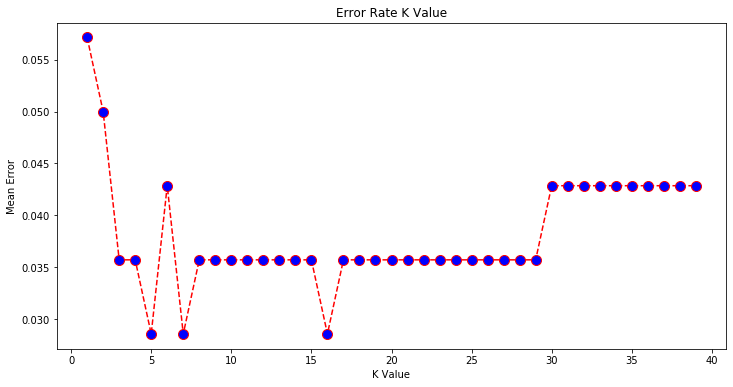

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [52]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
accuracy = forest.score(X_test, y_test)
print(accuracy)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9642857142857143
[[84  5]
 [ 0 51]]
             precision    recall  f1-score   support

          2       1.00      0.94      0.97        89
          4       0.91      1.00      0.95        51

avg / total       0.97      0.96      0.96       140



### Assessing feature importance with random forests
Using a random forest, we can measure the feature importance as the averaged impurity decrease computed from all decision trees in the forest, without making any assumptions about whether our data is linearly separable or not. Conveniently, the random forest implementation in scikit-learn already collects the feature importance values for us so that we can access them via the feature_importances_ attribute after fitting a RandomForestClassifier.

In [53]:
df.columns

Index(['clump_thickness', 'uniform_cell_size', 'uniform_cell_shape',
       'marginal_adhesion', 'single_epi_cell_size', 'bare_nuclei',
       'bland_chromation', 'normal_nucleoli', 'mitoses', 'class'],
      dtype='object')

In [54]:
feat_labels = df.columns[:-1]
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1] #[::-1] reverse the array
print(indices)
print(X_train.shape[1])
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]])) 

[2 1 5 6 4 0 7 3 8]
9
 1) uniform_cell_shape             0.312510
 2) uniform_cell_size              0.269828
 3) bare_nuclei                    0.140922
 4) bland_chromation               0.083937
 5) single_epi_cell_size           0.075457
 6) clump_thickness                0.045735
 7) normal_nucleoli                0.042487
 8) marginal_adhesion              0.022249
 9) mitoses                        0.006875


use list comprehensive, zip, sorting, and argument unpacking to output feature importance in descending order
zip(): returns iterator
sorted(): returns list, sorted()'s key can be function

In [55]:
'''
# Get numerical feature importances
importances = list(forest.feature_importances_) 
feat_labels = df.columns[:-1]
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feat_labels, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
'''

"\n# Get numerical feature importances\nimportances = list(forest.feature_importances_) \nfeat_labels = df.columns[:-1]\n# List of tuples with variable and importance\nfeature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feat_labels, importances)]\n# Sort the feature importances by most important first\nfeature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)\n# Print out the feature and importances \n[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];\n"

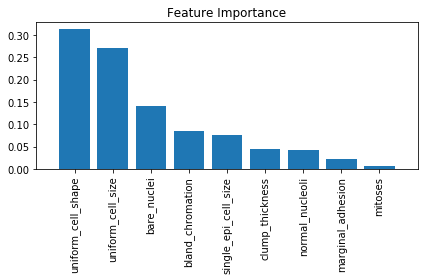

In [56]:
import matplotlib.pyplot as plt
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

### Visualizing a Single Decision Tree

In [57]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

# Pull out one tree from the forest
tree = forest.estimators_[5]

# Export the image to a dot data
df1 = df.drop(['class'], 1)
feature_list = list(df1.columns)
dot_data = export_graphviz(tree, out_file = None, 
                feature_names = feature_list, 
                rounded = True, precision = 1)
# Use dot data to create a graph
graph = graph_from_dot_data(dot_data)

# Write graph to a png file
graph.write_png('tree_wisconcin.png'); 

### Smaller tree for visualization

In [58]:
forest_small = RandomForestClassifier(criterion='gini',
                                n_estimators=10, 
                                max_depth = 3, random_state=1,
                                n_jobs=2)
forest_small.fit(X_train, y_train)
y_pred = forest_small.predict(X_test)
accuracy = forest_small.score(X_test, y_test)
print(accuracy)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9285714285714286
[[81  8]
 [ 2 49]]
             precision    recall  f1-score   support

          2       0.98      0.91      0.94        89
          4       0.86      0.96      0.91        51

avg / total       0.93      0.93      0.93       140



In [59]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
# Pull out one tree from the forest
tree_small = forest_small.estimators_[5]

# Export the image to a dot data
df1 = df.drop(['class'], 1)
feature_list = list(df1.columns)
dot_data = export_graphviz(tree_small, out_file = None, 
                feature_names = feature_list, 
                rounded = True, precision = 1)
# Use dot data to create a graph
graph = graph_from_dot_data(dot_data)

# Write graph to a png file
graph.write_png('tree_small_wisconcin.png');